In [53]:
import sys
import os
from typing import List, Dict, Tuple, Any

eval_folder_path = "exp/FedAvg_sasrec_on_sr_data_lr0.001_lstep1/ML-1M-Shadow-augmentation_10_shuffle_CE_loss"
print_log_path = os.path.join(eval_folder_path, "exp_print.log")
evaluation_log_path = os.path.join(eval_folder_path, "eval_results.log")


In [54]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [55]:

log_content = load_log_file(print_log_path)

In [56]:
## Federated Learning Infos
import ast

federated_configuration = {}

## Shadow Client Moderation
federated_configuration["shadow_client_num"] = ast.literal_eval(log_content.split('shadow_client_num: ')[1].split('\n')[0]) ## To int
#federated_configuration["client_num"] = ast.literal_eval(log_content.split('client_num: ')[1].split('\n')[0]) ## To int
federated_configuration["attacker_id"] = ast.literal_eval(log_content.split('attacker_id: ')[1].split('\n')[0]) ## To list
federated_configuration["total_round_num"] = ast.literal_eval(log_content.split('total_round_num: ')[1].split('\n')[0]) ## To int
federated_configuration["sample_client_num"] = ast.literal_eval(log_content.split('sample_client_num: ')[1].split('\n')[0]) ## To int
federated_configuration["local_update_steps"] = ast.literal_eval(log_content.split('local_update_steps: ')[2].split('\n')[0]) ## To int
federated_configuration["make_global_eval"] = ast.literal_eval(log_content.split('make_global_eval: ')[1].split('\n')[0]) ## To bool

print(federated_configuration)

{'shadow_client_num': 6040, 'attacker_id': [], 'total_round_num': 10000, 'sample_client_num': 16, 'local_update_steps': 1, 'make_global_eval': True}


In [57]:
if federated_configuration["make_global_eval"]:
    evaluation_log = load_log_file(evaluation_log_path)

In [58]:
import ast
import re

#local_results = log_content.split('(client:354)')[1:]

## if key the line has '(client:354)' or '(sr_sybil_attack_server:560)' then that line is a hit
local_train_report = []
global_eval_report = []
for line in log_content.split('\n') :
    if '(client:354)' in line or '(sr_sybil_attack_server:579)' in line :
        local_train_report.append(line)
    elif '(server:615)' in line :
        global_eval_report.append(line)

refined_local_results = []
refined_global_results = []

for local_result in local_train_report :
    refined_str = local_result.split('INFO: ')[1]
    refined_dict = ast.literal_eval(refined_str)
    refined_local_results.append(refined_dict)

for global_result in global_eval_report :
    refined_str = global_result.split('INFO: ')[1]
    refined_dict = ast.literal_eval(refined_str)
    refined_global_results.append(refined_dict)

if federated_configuration["make_global_eval"]:
    refined_global_results = []
    for line in evaluation_log.split('\n') :
        if line == '' :
            continue
        global_eval_result = ast.literal_eval(line)
        refined_global_results.append(global_eval_result)


print(f"total : {len(refined_local_results)} local results and {len(refined_global_results)} global results")
print(refined_local_results[0]['Round'])



total : 160000 local results and 51 global results
0


In [59]:
## segregate attacker and non-attacker clients

benign_clients_result = []
malicious_clients_result = []

def parse_client_id(role : str) -> int :
    """
    Parse the client id from the role string such as 'Client #593'.
    """
    return int(role.split('#')[1])

for line_num, local_result in enumerate(refined_local_results):
    current_id = parse_client_id(local_result['Role'])
    
    if current_id in federated_configuration["attacker_id"]:
        #print(f"{line_num},{current_id}")
        malicious_clients_result.append(local_result)
    else:
        benign_clients_result.append(local_result)

print(len(malicious_clients_result))
print(len(benign_clients_result))


0
160000


10000


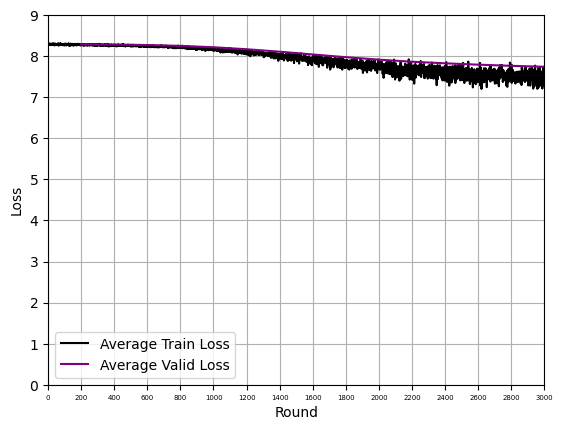

In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

## x-axis : round, y-axis : loss mean, std, max, min

## for each round loss values are
benign_loss = {i : [] for i in range(federated_configuration["total_round_num"])}
malicious_loss = {i : [] for i in range(federated_configuration["total_round_num"])}
global_valid_loss = {"round" : [], "loss" : []}
for local_result in benign_clients_result:
    current_round = local_result['Round']
    benign_loss[current_round].append(local_result['Results_raw']['train_avg_loss'])
    
for local_result in malicious_clients_result:
    current_round = local_result['Round']
    malicious_loss[current_round].append(local_result['Results_raw']['train_avg_loss'])

for global_result in refined_global_results:
    current_round = global_result['Round']
    if type(current_round) == str:
        continue
    if federated_configuration['make_global_eval']:
        current_global_val_avg_loss = global_result['Results_raw']['val_avg_loss']
    else :
        current_global_val_avg_loss =  global_result['Results_avg']['val_avg_loss']
    
    global_valid_loss['round'].append(current_round)
    global_valid_loss['loss'].append(current_global_val_avg_loss)

benign_datas = [value for key, value in benign_loss.items()]
avg_bening_loss = [np.mean(value) for key, value in benign_loss.items()]
bening_loss_std = [np.std(value) for key, value in benign_loss.items()]
max_std = np.max(bening_loss_std)
min_std = np.min(bening_loss_std)
normalized_bening_loss_std = [(value - min_std)/10 for value in bening_loss_std]
print(len(normalized_bening_loss_std))
#print(normalized_bening_loss_std)
#log_normalized_bening_loss_std = [np.log(value) for value in normalized_bening_loss_std]
fig, ax = plt.subplots()

avg_line_plot = ax.plot(list(benign_loss.keys()), avg_bening_loss, label='Average Train Loss', color='black')
## make histogram from the bottom transparent
#std_hist = ax.hist(normalized_bening_loss_std, bins = len(list(benign_loss.keys())), label = 'normalized_std_train_loss',color='black', alpha=0.5)
#std_histogram = ax.errorbar(list(benign_loss.keys()), avg_bening_loss, yerr=std_bening_loss, fmt='o', color='blue')

global_line_plot = ax.plot(global_valid_loss['round'], global_valid_loss['loss'], label='Average Valid Loss', color='purple')

plt.xlabel('Round')
ax.set_xticks(np.arange(0, federated_configuration["total_round_num"], 200))
plt.rcParams.update({'xtick.labelsize': 5})
ax.grid(True)
plt.ylabel('Loss')

handles, labels = ax.get_legend_handles_labels()
#empty_boxplot_label = mpatches.Patch(color='black', label='Train Loss')
#handles.extend([empty_boxplot_label]) 
ax.legend(handles=handles)
ax.set_ylim(0,9)
ax.set_xlim(0,3000)

plt.show()





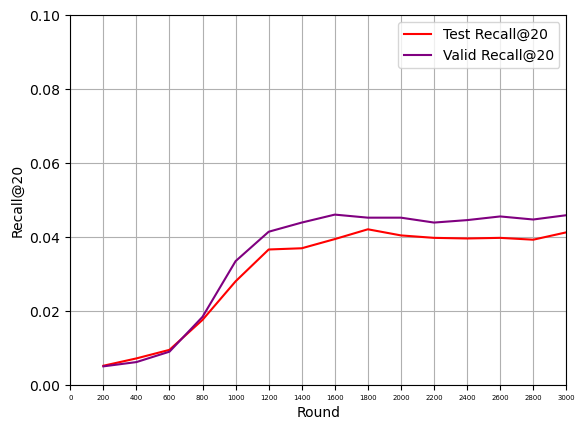

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

## Measure Recall & NDCG values here
## x-axis : round, y-axis : recall@20 valeus


global_valid_metrics = {"round" : [], "recall@20" : []}
global_test_metrics = {"round" : [], "recall@20" : []}

for global_result in refined_global_results:
    current_round = global_result['Round']
    if type(current_round) == str:
        continue
    if federated_configuration['make_global_eval']:
        current_global_val_metrics = global_result['Results_raw']['val_recall_20']
        current_global_test_metrics = global_result['Results_raw']['test_recall_20']
    else :
        None#current_global_val_avg_loss =  global_result['Results_avg']['val_avg_loss']
    global_valid_metrics['round'].append(current_round)
    global_valid_metrics['recall@20'].append(current_global_val_metrics)
    global_test_metrics['round'].append(current_round)
    global_test_metrics['recall@20'].append(current_global_test_metrics)


fig, ax = plt.subplots()

global_test_plot = ax.plot(global_test_metrics['round'], global_test_metrics['recall@20'], label='Test Recall@20', color='red')
global_valid_plot = ax.plot(global_valid_metrics['round'], global_valid_metrics['recall@20'], label='Valid Recall@20', color='purple')

x_ticks = np.arange(0, federated_configuration["total_round_num"], 200)
ax.set_xticks(x_ticks)
plt.rcParams.update({'xtick.labelsize': 5})
ax.grid(True)
plt.xlabel('Round')
plt.ylabel('Recall@20')
handles, labels = ax.get_legend_handles_labels()
#empty_boxplot_label = mpatches.Patch(color='black', label='Train Loss')
#handles.extend([empty_boxplot_label]) 
ax.legend(handles=handles)
ax.set_xlim(0,3000)
ax.set_ylim(0,0.1)
plt.show()